# Cyclic shifting and SW-MSA masking

This notebook is meant to help understand what happens during cycling shifting of patches in the computation of Shifted Windows Multi-head Self Attention.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from math import ceil, floor
from swin.modules import SwinTransformer
import tensorflow as tf

%matplotlib inline

2023-07-05 16:36:18.110086: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-05 16:36:18.136710: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


We define a bunch of constants which determine the size of the input feature map to the SW-MSA.

In [2]:
patch_size = 2 # in px
map_size = 8 # in px
n_patches = ceil(map_size / patch_size)

res = int(map_size / patch_size) # in # of patches
window_size = 2 # in # of patches
shift_size = 1 # in # of patches

windows_res = int(map_size / (window_size * patch_size)) # in windows

We first plot the feature map with windows overlaid on top.
Red lines denote the windows without any shifting applied, while cyan lines denote windows after shifting.

We then plot the same feature map after having applied cyclic shift.
We can see that patches are simultaneously moved to the top and to the left, with those overflowing ending at the bottom and to the right.
Again, red lines denote the windows in which the feature map will be split into.

We can clearly see that, after shifting, windows correspond to those painted in Cyan in the first image.
It's also worth mentioning that some windows are made of patches which were not adjacent in the original feature map.
This reason is why we need a mask during SW-MSA.

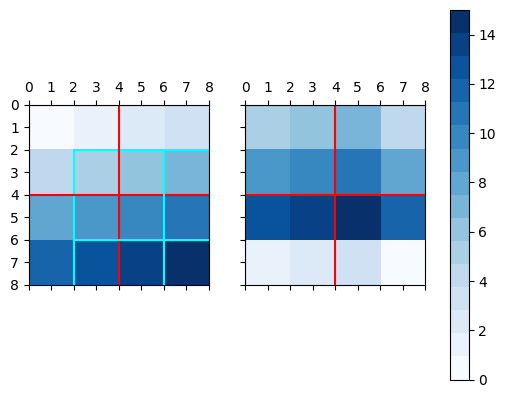

In [3]:
patches_cm = mpl.colors.ListedColormap(plt.cm.Blues(np.linspace(0, 1, n_patches**2)), "Patches colormap")

fm = np.zeros((map_size, map_size))

color = 0
for x in range(n_patches):
    for y in range(n_patches):
        # print(f"{x*patch_size}:{(x+1)*patch_size}, {y*patch_size}:{(y+1)*patch_size} -> {color}")
        fm[x*patch_size:(x+1)*patch_size,y*patch_size:(y+1)*patch_size] = color
        color += 1

shifted_fm = np.roll(
    fm, shift=[-shift_size * patch_size, -shift_size * patch_size], axis=[0, 1]
)

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
for i, data in enumerate([fm, shifted_fm]):
    im = axes[i].matshow(data, cmap=patches_cm, extent=[0, map_size, map_size, 0])
    for j in range(floor(map_size / (window_size * patch_size))):
        axes[i].add_artist(
            lines.Line2D(
                [
                    window_size * patch_size * j,
                    window_size * patch_size * j
                ],
                [
                    0,
                    map_size
                ],
                color="Red"
            )
        )
        axes[i].add_artist(
            lines.Line2D(
                [
                    0,
                    map_size
                ],
                [
                    window_size * patch_size * j,
                    window_size * patch_size * j
                ],
                color="Red"
            )
        )

        if i == 0: # Only draw shifted windows boundaries on the first image
            axes[i].add_artist(
                lines.Line2D(
                    [
                        window_size * patch_size * j + shift_size * patch_size,
                        window_size * patch_size * j + shift_size * patch_size
                    ],
                    [
                        0  + shift_size * patch_size,
                        map_size
                    ],
                    color="Cyan"
                )
            )
            axes[i].add_artist(
                lines.Line2D(
                    [
                        0  + shift_size * patch_size,
                        map_size
                    ],
                    [
                        window_size * patch_size * j + shift_size * patch_size,
                        window_size * patch_size * j + shift_size * patch_size
                    ],
                    color="Cyan"
                )
            )
fig.colorbar(im, ax=axes.ravel().tolist())

We now proceed to build and visualize the mask which will be used during SW-MSA.
This mask is to prevent patches to pay attention to other patches in the same window which are not really adjacent to each other due to the cyclic shift applied earlier.

The first image depicts, step by step, how patches in each window get a value assigned denoting their origin.
For example, the top-left-most window only contains patches coming from the same window which gets the value 0 assigned.
On the other hand, the bottom-right-most windows is made of patches coming from a variety of windows, each getting a different value assigned.

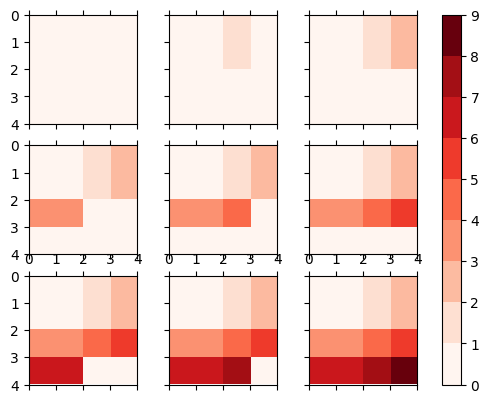

In [4]:
mask = np.zeros([1, res, res, 1])

h_slices = (
    slice(0, -window_size),
    slice(-window_size, -shift_size),
    slice(-shift_size, None),
)
w_slices = (
    slice(0, -window_size),
    slice(-window_size, -shift_size),
    slice(-shift_size, None),
)

windows_cm = mpl.colors.ListedColormap(
    plt.cm.Reds(np.linspace(0, 1, len(h_slices) * len(w_slices))), 
    "Patches colormap"
)
fig, axes = plt.subplots(
    ceil(len(h_slices) * len(w_slices) / 3), 
    3, 
    sharex=True, 
    sharey=True
)

i = 0
for h_slice in h_slices:
    for w_slice in w_slices:
        mask[:, h_slice, w_slice, :] = i

        im = axes[floor(i / 3), i % 3].matshow(
            mask[0, :, :, 0], 
            cmap=windows_cm, 
            extent=[0, res, res, 0], 
            vmin=0, 
            vmax=len(windows_cm.colors)
        )

        i += 1

fig.colorbar(im, ax=axes.ravel().tolist())

This mask cannot be used as is, so we need to do some further processing.

The first step is to split it into windows, as can be seen in the first figure.

We must remember that the self-attention mechanism performs the calculation between each pair of patches in a window.
For pair of patches that were distant prior to cyclic shifting we want the attention value to be negative, so that it will result in a value close to 0 when put through the SoftMax operation.
This can be achieved by summing the attention matrix with a mask matrix having cells with large negative values for those pairs of cells distant from each other.

Currently, however, (1) our mask does not have the right shape and the (2) right values.
To fix it, we need to do the following:

1.
    - We flatten each window by concatenating its patches along a single axis, as can be seen in the second figure.
    - We broadcast this flattened vector into a square matrix by repeating its values for each row. We do the same with the transposed vector, turning it into a matrix by repeating its values for each column.
    - We subtract the first matrix to the second: this yields a matrix with zeros where the two subtracted values were identical and other numbers where values were different. 0 denotes a pair of patches which are adjacent and for which the computation of attention is valid.
2. We transform every non-zero value into a big negative value (in this case, -100).

Our final mask can be seen in the third figure.


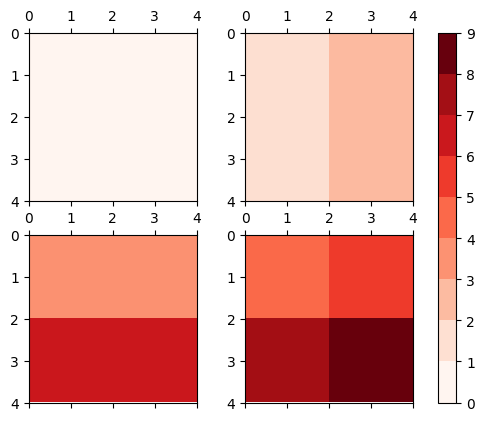

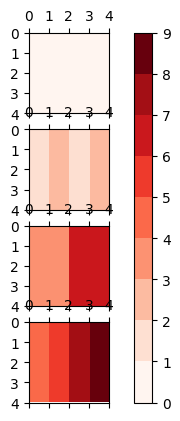

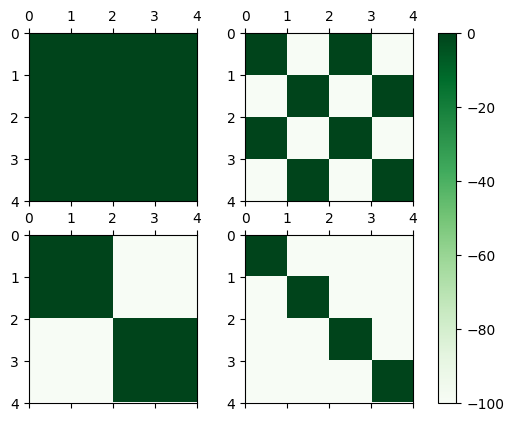

In [5]:
mask_windows = SwinTransformer.window_partition(mask, window_size) # (n_windows * 1, window_size, window_size, 1)
fig, axes = plt.subplots(windows_res, windows_res)
for i in range(windows_res):
    for j in range(windows_res):
        im = axes[i, j].matshow(
            mask_windows.numpy()[i + j + (i * (axes.shape[1] - 1)), :, :, 0], 
            cmap=windows_cm, 
            extent=[0, res, res, 0], 
            vmin=0, 
            vmax=len(windows_cm.colors)
        )
fig.colorbar(im, ax=axes.ravel().tolist())

mask_windows = tf.reshape(mask_windows, [-1, window_size * window_size])

fig, axes = plt.subplots(mask_windows.shape[0])
for i in range(axes.shape[0]):
        im = axes[i].matshow(
            mask_windows.numpy()[i].reshape((1, -1)), 
            cmap=windows_cm,
            extent=[0, res, res, 0], 
            vmin=0, 
            vmax=len(windows_cm.colors),
        )
fig.colorbar(im, ax=axes.ravel().tolist())

attn_mask = tf.expand_dims(mask_windows, 1) - tf.expand_dims(mask_windows, 2)

attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
fig, axes = plt.subplots(windows_res, windows_res)
for i in range(windows_res):
    for j in range(windows_res):
        im = axes[i, j].matshow(
            attn_mask.numpy()[i + j + (i * (axes.shape[1] - 1))],
            extent=[0, res, res, 0],
            cmap="Greens",
            vmin=-100,
            vmax=0
        )
fig.colorbar(im, ax=axes.ravel().tolist())